In [2]:
import numpy as np
import pandas as pd
import math
import seaborn as sns
import plotly.express as px
import scipy.stats
from matplotlib import pyplot as plt
from tqdm import tqdm
from mpl_toolkits.mplot3d import Axes3D


# Torch
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset

#Sklearn
from sklearn import svm
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_regression
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import RFE
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold

Settings

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

### Loading dataset

In [4]:
ds_original = pd.read_csv('..\..\data\external\dataset_phishing.csv', header=0, delimiter=',',decimal=',')

print("Original dataset dimensions:", ds_original.shape)

Original dataset dimensions: (11430, 89)


We will try to predict the status of an url

In [5]:
y = ds_original[:]["status"] 
x = ds_original.drop(columns = "status")

print("Number of samples:", x.shape[0])
print("Number of features:", x.shape[1])

Number of samples: 11430
Number of features: 88


## Data preprocessing

### - Data cleaning

Searching for empty or unknown values in the dataset

In [6]:
print("Null values:", x.isnull().sum().sum())
print("NA values:", x.isna().sum().sum())

print("\nColumns with values equal to -1:\n", ((x == -1).sum())[((x == -1).sum() != 0).tolist()])

Null values: 0
NA values: 0

Columns with values equal to -1:
 domain_registration_length      46
domain_age                    1781
dtype: int64


Replacing unknown values with the mean of the known values

In [7]:
known_domain_age = x.loc[x['domain_age'] != -1, 'domain_age']
mean_domain_age = known_domain_age.sum()/len(known_domain_age)
mean_domain_age

x.loc[x["domain_age"] == -1, 'domain_age'] = mean_domain_age

known_domain_registration_length = x.loc[x['domain_registration_length'] != -1, 'domain_registration_length']
mean_domain_registration_length = known_domain_registration_length.sum()/len(known_domain_registration_length)
mean_domain_registration_length

x.loc[x["domain_registration_length"] == -1, 'domain_registration_length'] = mean_domain_registration_length

In [8]:
(x[["domain_age", "domain_registration_length"]] == -1).sum()

domain_age                    0
domain_registration_length    0
dtype: int64

The "url" feature is not useful since all the information that can be extracted from it is already collected in the rest of columns.

In [9]:
x = x.drop(columns = "url")

### - Data conversion

Since we are trying to predict the status ($Y$ vector), we need to convert the _Phishing_ and _Legitimate_ labels to $1$ and $0$.

In [10]:
print(y.describe())

status_labels = y.copy() # "string" labels

y = y.replace({"phishing" : 1, "legitimate" : 0})

print("\nY content:", set(y))
print("\nY shape:", y.shape)
print("\nX shape:", x.shape)

count          11430
unique             2
top       legitimate
freq            5715
Name: status, dtype: object

Y content: {0, 1}

Y shape: (11430,)

X shape: (11430, 87)


The $X$ columns with float numbers are actually stored as an unknown _object_ variable. A conversion to float type is needed

In [11]:
type_of_cols = [x.dtypes == object][0]
for col in range(x.shape[1]):
    if type_of_cols[col]:
        x[x.columns[col]] = x[x.columns[col]].astype('float')

### - Data normalization

First we have to determine which features are categorical.

In [12]:
categorical_features = ["ip", "http_in_path", "https_token", "punycode", "port", "tld_in_path", "tld_in_subdomain", "abnormal_subdomain", "prefix_suffix", "random_domain", "shortening_service", "path_extension",
"domain_in_brand", "brand_in_subdomain", "brand_in_path", "suspecious_tld", "login_form", "external_favicon", "submit_email", "sfh", "iframe", "popup_window", "onmouseover", 
"right_clic", "empty_title", "domain_in_title", "domain_with_copyright", "whois_registered_domain", "dns_record", "google_index"]

non_categorical_features = [i for i in x.columns if (i not in categorical_features)]

x_non_categorical = x[non_categorical_features]
x_categorical = x[categorical_features]

In [13]:
scaler = StandardScaler() # Standardize features by removing the mean and scaling to unit variance.
#scaler = MinMaxScaler()

x_non_categorical_standard = scaler.fit_transform(x_non_categorical)

df = pd.DataFrame(x_non_categorical_standard)
df.columns = non_categorical_features

x_standard = pd.concat([df, x_categorical], axis = 1)

## Feature selection

A good idea for discarding some columns would be to drop those whose mean is very close to 0. We can do this only with the features that represent some kind of counter because that means that most of the samples doesn't register that feature.

In [14]:
columns_to_drop = []

for col in range(x.shape[1]):
    name_of_feature = x.columns[col]
    if abs(np.mean(x[name_of_feature])) <= 0.01:
        columns_to_drop.append(name_of_feature)
        
x[columns_to_drop].describe()

nb_or  nb_tilde   nb_star  nb_comma  nb_dollar  nb_dslash  punycode  \
count 11430.000 11430.000 11430.000 11430.000  11430.000  11430.000 11430.000   
mean      0.000     0.007     0.001     0.004      0.002      0.007     0.000   
std       0.000     0.081     0.026     0.103      0.077      0.081     0.019   
min       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
25%       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
50%       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
75%       0.000     0.000     0.000     0.000      0.000      0.000     0.000   
max       0.000     1.000     1.000     4.000      6.000      1.000     1.000   

           port  path_extension  nb_external_redirection  brand_in_subdomain  \
count 11430.000       11430.000                11430.000           11430.000   
mean      0.002           0.000                    0.003               0.004   
std       0.049           0.013                    0.056               0.064   
min       0.000           0.000                    0.000               0.000   
25%       0.000           0.000                    0.000               0.000   
50%       0.000           0.000                    0.000               0.000   
75%       0.000           0.000                    0.000               0.000   
max       1.000           1.000                    1.000               1.000   

       brand_in_path  ratio_nullHyperlinks  ratio_intRedirection  \
count      11430.000             11430.000             11430.000   
mean           0.005                 0.000                 0.000   
std            0.070                 0.000                 0.000   
min            0.000                 0.000                 0.000   
25%            0.000                 0.000                 0.000   
50%            0.000                 0.000                 0.000   
75%            0.000                 0.000                 0.000   
max            1.000                 0.000                 0.000   

       ratio_intErrors  submit_email       sfh    iframe  popup_window  \
count        11430.000     11430.000 11430.000 11430.000     11430.000   
mean             0.000         0.000     0.000     0.001         0.006   
std              0.000         0.000     0.000     0.036         0.077   
min              0.000         0.000     0.000     0.000         0.000   
25%              0.000         0.000     0.000     0.000         0.000   
50%              0.000         0.000     0.000     0.000         0.000   
75%              0.000         0.000     0.000     0.000         0.000   
max              0.000         0.000     0.000     1.000         1.000   

       onmouseover  right_clic  
count    11430.000   11430.000  
mean         0.001       0.001  
std          0.034       0.037  
min          0.000       0.000  
25%          0.000       0.000  
50%          0.000       0.000  
75%          0.000       0.000  
max          1.000       1.000

Veient els màxims i mínims d'aquestes columnes queda clar que totes aquestes columnes indiquen un compte d'alguna cosa o són variables binaries i, en qualsevol cas, no donen suficient informació per ajudar en la classifició.

In [15]:
#x = x.drop(columns = columns_to_drop)
#x_standard = x_standard.drop(columns = columns_to_drop)

print("Number of samples:", x.shape[0])
print("Number of features:", x.shape[1])

Number of samples: 11430
Number of features: 87


In [16]:
def split_data(x, y, train_ratio=0.8):
    indices = np.arange(x.shape[0])
    np.random.shuffle(indices)
    n_train = int(np.floor(x.shape[0]*train_ratio))
    indices_train = indices[:n_train]
    indices_val = indices[n_train:] 
    x_train = x[indices_train, :]
    y_train = y[indices_train]
    x_val = x[indices_val, :]
    y_val = y[indices_val]
    return x_train, y_train, x_val, y_val

# Dividim dades d'entrenament
x_train, y_train, x_val, y_val = split_data(x_standard.values, y)

r2_table = np.zeros((x_train.shape[1], 2))

for i in range(x_train.shape[1]):
    x_t = x_train[:,i] # seleccionem atribut i en conjunt de train
    x_v = x_val[:,i] # seleccionem atribut i en conjunt de val.
    x_t = np.reshape(x_t,(x_t.shape[0],1))
    x_v = np.reshape(x_v,(x_v.shape[0],1))

    regr = LinearRegression()
    regr.fit(x_t, y_train)
    
    r2 = r2_score(y_val, regr.predict(x_v))
    
    r2_table[i, 1] = r2
    r2_table[i, 0] = i

We create a reduced dataset with the best atributes

In [17]:
best_atributes = r2_table[r2_table[:, 1].argsort()[::-1]][:,0].astype('int')


reduced_dataset_standard = x_standard[x_standard.columns[best_atributes[:15]]]
reduced_dataset_standard = reduced_dataset_standard.assign(status = y.values)


reduced_dataset = x[x_standard.columns[best_atributes[:15]]]
reduced_dataset = reduced_dataset.assign(status = y.values)



X = reduced_dataset.drop(columns='status').values
X_standard = reduced_dataset_standard.drop(columns='status').values

Y = reduced_dataset.filter(['status']).values

Relació entre variables no categoriques

In [18]:
reduced_dataset.insert(reduced_dataset.shape[1], "Status", status_labels)
#relacio = sns.pairplot(reduced_dataset, hue = "Status", y_vars = ["status"], x_vars = list(reduced_dataset.columns[:-2]))
#relacio.fig.set_size_inches(15,2)
#relacio._legend.set_title("Status")
reduced_dataset.drop(columns = "Status")
reduced_dataset = reduced_dataset.drop(columns = "Status")

Correlació entre les variables independents i la dependent

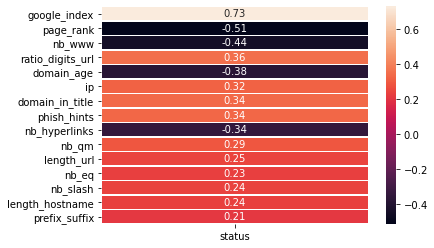

In [19]:
correlacio = reduced_dataset.corr()

plt.figure()
ax = sns.heatmap(pd.DataFrame(correlacio["status"][:-1]), annot=True, linewidths=.5)

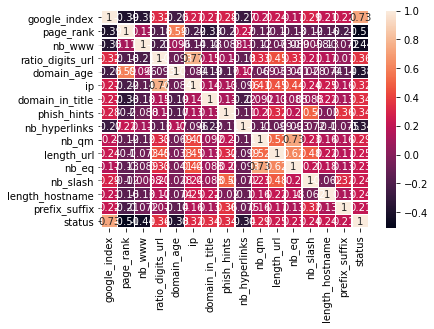

In [20]:
correlacio = reduced_dataset.corr()

plt.figure()
ax = sns.heatmap(pd.DataFrame(correlacio), annot=True, linewidths=.5)

In [21]:
#relacio = sns.pairplot(reduced_dataset, hue = "status")

Utilities

In [22]:
def visualize_confusion_matrix(y_pred, y_real):
    # mostra la matriu de confusió
    cm = confusion_matrix(y_real, y_pred)
    plt.subplots(figsize=(10, 6))
    sns.heatmap(cm, annot = True, fmt = 'g')
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

PCA Analysis

In [23]:
X_torch = torch.tensor(X_standard)
Y_torch = torch.tensor(Y)

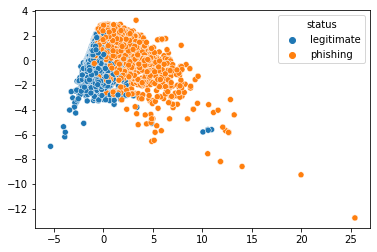

In [24]:
V = torch.pca_lowrank(X_torch, q=None, center=False, niter=100)[2]
pca = torch.matmul(X_torch, V[:, :2])

sns.scatterplot(x = pca[:, 0], y = pca[:, 1], hue = status_labels);

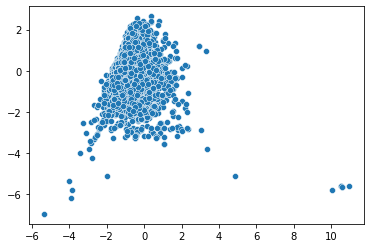

In [25]:
sns.scatterplot(x = pca[reduced_dataset_standard["status"] == 0 , 0], y = pca[reduced_dataset_standard["status"] == 0 , 1]);

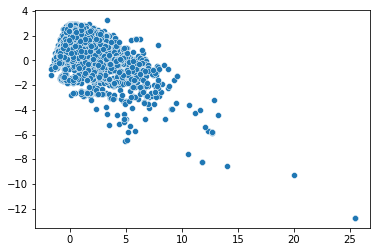

In [26]:
sns.scatterplot(x = pca[reduced_dataset_standard["status"] == 1 , 0], y = pca[reduced_dataset_standard["status"] == 1 , 1]);

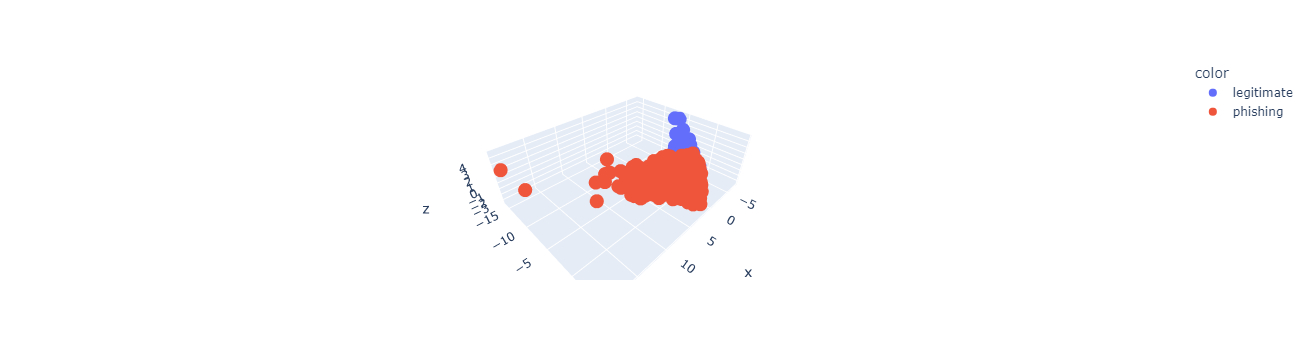

In [25]:
V = torch.pca_lowrank(X_torch, q=None, center=True, niter=3)[2]
pca = torch.matmul(X_torch, V[:, :3])

df = px.data.iris()
fig = px.scatter_3d(x = pca[:, 0], y = pca[:, 1], z = pca[:, 2], color = status_labels)
fig.show()

#### Logistic regression

In [26]:
class LogisticRegression(torch.nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = torch.nn.Linear(input_dim, output_dim)
    def forward(self, x):
        outputs = torch.sigmoid(self.linear(x))
        return outputs

In [38]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_standard, Y, test_size=0.80, random_state=42)

X_train, X_test = torch.Tensor(X_train), torch.Tensor(X_test)
y_train, y_test = torch.Tensor(y_train), torch.Tensor(y_test)

X_torch, Y_torch = torch.Tensor(X_standard), torch.Tensor(Y)

data_torch = torch.cat((X_torch, Y_torch), 1)

In [28]:
epochs = 50000
input_dim = X.shape[1] # Independent variables 
output_dim = 1 # Single binary output 
learning_rate = 0.05

In [29]:
model = LogisticRegression(input_dim,output_dim) #Creem el model

criterion = torch.nn.BCELoss() # Definim el criteri de la funció de cost

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Definim el mètode per reduir el cost

In [30]:
losses = []
losses_test = []
Iterations = []
iter = 0
for epoch in tqdm(range(int(epochs)),desc='Training Epochs'):
    x = X_train
    labels = y_train
    optimizer.zero_grad() # Setting our stored gradients equal to zero
    outputs = model(X_train)
    loss = criterion(outputs, labels) 
    
    loss.backward() # Computes the gradient of the given tensor w.r.t. the weights/bias
    
    optimizer.step() # Updates weights and biases with the optimizer (SGD)
    
    iter += 1
    if iter % (epochs/5) == 0:
        with torch.no_grad():
            # Calculating the loss and accuracy for the test dataset
            correct_test = 0
            total_test = 0
            outputs_test = model(X_test)
            loss_test = criterion(outputs_test, y_test)
            
            predicted_test = outputs_test.round().detach().numpy()
            total_test += y_test.size(0)
            correct_test += np.sum(predicted_test == y_test.detach().numpy())
            accuracy_test = 100 * correct_test/total_test
            losses_test.append(loss_test.item())
            
            # Calculating the loss and accuracy for the train dataset
            total = 0
            correct = 0
            total += y_train.size(0)
            correct += np.sum(outputs.round().detach().numpy() == y_train.detach().numpy())
            accuracy = 100 * correct/total
            losses.append(loss.item())
            Iterations.append(iter)
            
            print(f"Iteration: {iter}. \nTest - Loss: {loss_test.item()}. Accuracy: {accuracy_test}")
            print(f"Train -  Loss: {loss.item()}. Accuracy: {accuracy}\n")

Training Epochs:  21%|██        | 10251/50000 [00:07<00:20, 1905.76it/s]

Iteration: 10000. 
Test - Loss: 0.19980479776859283. Accuracy: 92.66185476815399
Train -  Loss: 0.18771997094154358. Accuracy: 93.30708661417323



Training Epochs:  40%|████      | 20184/50000 [00:13<00:14, 2018.64it/s]

Iteration: 20000. 
Test - Loss: 0.2003050595521927. Accuracy: 92.54155730533684
Train -  Loss: 0.18722622096538544. Accuracy: 93.21959755030622



Training Epochs:  60%|██████    | 30248/50000 [00:17<00:08, 2319.19it/s]

Iteration: 30000. 
Test - Loss: 0.20038370788097382. Accuracy: 92.48687664041995
Train -  Loss: 0.1871906965970993. Accuracy: 93.08836395450568



Training Epochs:  81%|████████  | 40300/50000 [00:22<00:04, 2267.61it/s]

Iteration: 40000. 
Test - Loss: 0.20038112998008728. Accuracy: 92.48687664041995
Train -  Loss: 0.18718692660331726. Accuracy: 93.1321084864392



Training Epochs: 100%|██████████| 50000/50000 [00:27<00:00, 1798.40it/s]

Iteration: 50000. 
Test - Loss: 0.2003750056028366. Accuracy: 92.49781277340333
Train -  Loss: 0.18718641996383667. Accuracy: 93.1321084864392



In [31]:
"""def train(model, device, train_loader, optimizer, criterion, X, Y):
    losses = []
    model.train()
    t = tqdm.tqdm(enumerate(x), total=len(X))
    t.set_description('Train')
    for batch_idx, (data, target) in t:
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
        t.set_postfix(loss=loss.item())

    return losses""";

In [32]:
"""def test(model, device, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    totals = 0
    all_preds = []
    all_targets = []
    
    with torch.no_grad():
        t = tqdm.tqdm(test_loader, total=len(test_loader))
        t.set_description('Test ')
        for data, target in t:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += criterion(output, target).item() * data.shape[0]  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            totals += len(target)
            t.set_postfix(loss=test_loss/totals, accuracy=100.*correct/totals)
            all_preds.extend(np.asarray(pred))
            all_targets.extend(np.asarray(target))

    test_loss /= len(test_loader.dataset)
    accuracy = 100. * correct / len(test_loader.dataset)
    
    # visualize confusion matrix?
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset), accuracy))
    return test_loss, accuracy""";

In [33]:
k_folds = 4
num_epochs = 1
input_dim = X.shape[1] # Independent variables 
output_dim = 1 # Single binary output 
learning_rate = 0.05

results = {}

parameters = []

kfold = KFold(n_splits=k_folds, shuffle=True)
criterion = torch.nn.BCELoss() # Definim el criteri de la funció de cost

for fold, (train_ids, test_ids) in enumerate(kfold.split(reduced_dataset_standard)):
    # Print
    print(f'FOLD {fold}')
    print('--------------------------------')
    
    # Sample elements randomly from a given list of ids, no replacement.
    train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
    test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
    
    # Define data loaders for training and testing data in this fold
    trainloader = torch.utils.data.DataLoader(
                      reduced_dataset_standard.to_numpy(), 
                      batch_size=10, sampler=train_subsampler)
    testloader = torch.utils.data.DataLoader(
                      reduced_dataset_standard.to_numpy(),
                      batch_size=10, sampler=test_subsampler)
    
    # Init the neural network
    model = LogisticRegression(input_dim,output_dim)
    #network.apply(reset_weights)
    
    
    # Initialize optimizer
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate) # Definim el mètode per reduir el cost
    
    # Run the training loop for defined number of epochs
    for epoch in range(0, num_epochs):

        # Print epoch
        print(f'Starting epoch {epoch+1}')

        # Set current loss value
        current_loss = 0.0

        # Iterate over the DataLoader for training data
        #print(trainloader)
        for i, data in enumerate(trainloader, 0):
        
            # Get inputs
            #print(data.shape)
            inputs = data[:,:-1].float()
            targets = data[:, -1].reshape((inputs.shape[0],1)).float()

            # Zero the gradients
            optimizer.zero_grad()

            # Perform forward pass
            outputs = model(inputs)

            # Compute loss
            loss = criterion(outputs, targets)

            # Perform backward pass
            loss.backward()

            # Perform optimization
            optimizer.step()

            # Print statistics
            current_loss += loss.item()
            if i % 500 == 499:
                print('Loss after mini-batch %5d: %.3f' %
                      (i + 1, current_loss / 500))
                current_loss = 0.0
            
    # Process is complete.
    print('Training process has finished. Saving trained model.')

    # Print about testing
    print('Starting testing')
    
    # Saving the model
    save_path = f'../../models/LogisticRegression/logiReg-fold-{fold}.pth'
    torch.save(model.state_dict(), save_path)
    
    # Saving parameters of the linear model
    parameters.append([param.data for name, param in model.named_parameters()]) 

    # Evaluationfor this fold
    correct, total = 0, 0
    with torch.no_grad():
        # Iterate over the test data and generate predictions
        for i, data in enumerate(testloader, 0):
            # Get inputs
            inputs = data[:,:-1].float()
            targets = data[:, -1].reshape((inputs.shape[0],1)).float()

            # Generate outputs
            outputs = model(inputs)

            # Set total and correct
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            #correct += (predicted == targets).sum().item()
            #print(outputs, targets.shape)
            
            correct += np.sum(outputs.round().detach().numpy() == targets.detach().numpy())

        # Print accuracy
        print('Accuracy for fold %d: %d %%' % (fold, 100.0 * correct / total))
        print('--------------------------------')
        print(correct, total)
        results[fold] = 100.0 * (correct / total)

    # Print fold results
    print(f'K-FOLD CROSS VALIDATION RESULTS FOR {k_folds} FOLDS')
    print('--------------------------------')
    sum = 0.0
    for key, value in results.items():
        print(f'Fold {key}: {value} %')
        sum += value
    print(f'Average: {sum/len(results.items())} %')

FOLD 0
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 0.280
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 0: 91 %
--------------------------------
2624 2858
K-FOLD CROSS VALIDATION RESULTS FOR 4 FOLDS
--------------------------------
Fold 0: 91.81245626312106 %
Average: 91.81245626312106 %
FOLD 1
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 0.285
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 1: 92 %
--------------------------------
2635 2858
K-FOLD CROSS VALIDATION RESULTS FOR 4 FOLDS
--------------------------------
Fold 0: 91.81245626312106 %
Fold 1: 92.19734079776067 %
Average: 92.00489853044087 %
FOLD 2
--------------------------------
Starting epoch 1
Loss after mini-batch   500: 0.288
Training process has finished. Saving trained model.
Starting testing
Accuracy for fold 2: 92 %
--------------------------------
2651 2857
K-FOLD CROS

In [34]:
def logistic_func(x):
    return 1 / (1 + np.exp(-x))

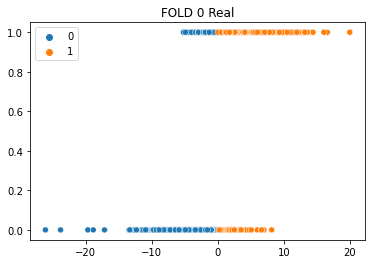

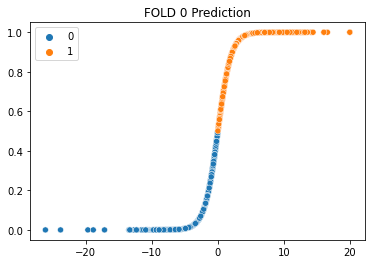

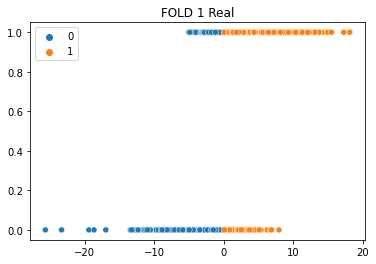

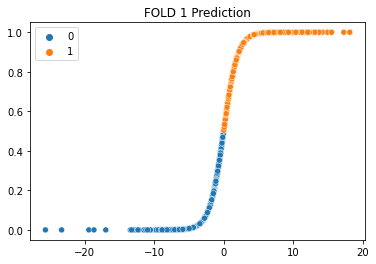

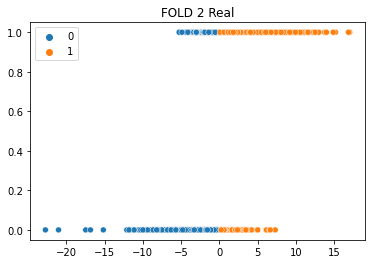

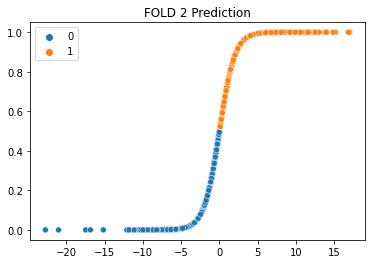

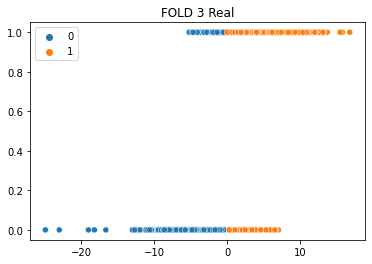

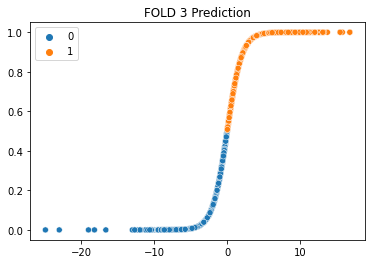

In [35]:
for fold, fold_parameters in enumerate(parameters):
    aux = []
    for x in X_standard:
        params = fold_parameters[0].numpy()
        bias = fold_parameters[1].numpy()
        
        p = np.concatenate((bias.reshape(1,1), params.transpose()))        
        x = np.concatenate((np.ones((1, 1)), x.reshape(x.shape[0], 1)))
        
        pred = np.dot(x.T, p)
        aux.append(pred[0][0])
    preds = [logistic_func(i) for i in aux]
    
    color_pred = [1 if i >= 0 else 0 for i in aux]
    
    plt.figure()
    plt.title("FOLD "+ str(fold) + " Real")
    sns.scatterplot(x = aux, y=Y.T[0], hue=color_pred, )
    plt.figure()
    plt.title("FOLD "+ str(fold) + " Prediction")
    sns.scatterplot(x=aux, y=preds, hue=color_pred)

### SVM

Creating the training and test datasets:

In [99]:
X_train, X_test, y_train, y_test = \
    train_test_split(X_standard, Y, test_size=0.1, random_state=1)

Finding the best hyperparameters for all the 6 SVM models (Linear, RBF, Sigmoid and degree 1, 2 and 3 polynomial):

In [117]:
Cs = [0.01*i for i in range(1, 101)] + [0.5*i for i in range(2, 21)]
gammas = [1/X_train.shape[1]] + [0.02*i for i in range(1, 51)]
coefs = [0.1*i for i in range(11)] + [0.5*i for i in range(2, 11)]

- ##### Linear

In [132]:
Cs = [0.01*i for i in range(1, 101)] + [0.5*i for i in range(2, 21)]

accuraciesLinear = np.zeros([len(Cs), 2])

idx = 0
for c in Cs:
    model = svm.SVC(kernel = 'linear', C=c, max_iter = -1)
    model.fit(X_train,y_train.flatten())
    predict = model.predict(X_test)
    
    accuraciesLinear[idx][0] = (predict == y_test.flatten()).sum()/predict.size #Accuracy
    accuraciesLinear[idx][1] = c
    
    idx += 1

In [133]:
accuraciesLinear[np.argmax(accuraciesLinear[:, 0])]

array([0.92213473, 0.38      ])

- ##### RBF

In [134]:
Cs = [0.1*i for i in range(1, 101)] + [0.5*i for i in range(2, 21)]
gammas = [1/X_train.shape[1]] + [0.02*i for i in range(1, 51)]

accuraciesRBF = np.zeros([len(Cs)*len(gammas), 3])

idx = 0
for g in gammas:
    for c in Cs:            
        model = svm.SVC(kernel = 'rbf', C=c, gamma = g, max_iter = -1)
        model.fit(X_train,y_train.flatten())
        predict = model.predict(X_test)

        accuraciesRBF[idx][0] = (predict == y_test.flatten()).sum()/predict.size #Accuracy
        accuraciesRBF[idx][1] = c
        accuraciesRBF[idx][2] = g
        
        idx += 1

KeyboardInterrupt: 

In [143]:
accuraciesRBF[np.argmax(accuraciesRBF[:, 0])]#Podria subir la magnitud de las C que pruebo

array([ 0.96762905, 10.        ,  0.14      ])

- ##### Sigmoid

In [146]:
Cs = [0.01*i for i in range(1, 101)] + [0.5*i for i in range(2, 21)]
gammas = [1/X_train.shape[1]] + [0.02*i for i in range(1, 51)]

accuraciesSigmoid = np.zeros([len(Cs)*len(gammas), 3])

idx = 0
for g in gammas:
    for c in Cs:
        if idx % 100 == 0:
            print("Progress: "+str(idx)+"/"+str(len(Cs)*len(gammas)))
        model = svm.SVC(kernel = 'sigmoid', C=c, gamma = g, max_iter = -1)
        model.fit(X_train,y_train.flatten())
        predict = model.predict(X_test)

        accuraciesSigmoid[idx][0] = (predict == y_test.flatten()).sum()/predict.size #Accuracy
        accuraciesSigmoid[idx][1] = c
        accuraciesSigmoid[idx][2] = g
        
        idx += 1

Progress: 0/6069
Progress: 100/6069
Progress: 200/6069
Progress: 300/6069
Progress: 400/6069
Progress: 500/6069
Progress: 600/6069
Progress: 700/6069
Progress: 800/6069
Progress: 900/6069
Progress: 1000/6069
Progress: 1100/6069
Progress: 1200/6069
Progress: 1300/6069
Progress: 1400/6069
Progress: 1500/6069
Progress: 1600/6069
Progress: 1700/6069
Progress: 1800/6069
Progress: 1900/6069
Progress: 2000/6069
Progress: 2100/6069
Progress: 2200/6069
Progress: 2300/6069
Progress: 2400/6069
Progress: 2500/6069
Progress: 2600/6069
Progress: 2700/6069
Progress: 2800/6069
Progress: 2900/6069
Progress: 3000/6069
Progress: 3100/6069
Progress: 3200/6069
Progress: 3300/6069
Progress: 3400/6069
Progress: 3500/6069
Progress: 3600/6069
Progress: 3700/6069
Progress: 3800/6069
Progress: 3900/6069
Progress: 4000/6069
Progress: 4100/6069
Progress: 4200/6069
Progress: 4300/6069
Progress: 4400/6069
Progress: 4500/6069
Progress: 4600/6069
Progress: 4700/6069
Progress: 4800/6069
Progress: 4900/6069
Progress: 50

In [1]:
accuraciesSigmoid[np.argmax(accuraciesSigmoid[:, 0])]

NameError: name 'accuraciesSigmoid' is not defined

Polynomial Degree 1

In [ ]:
accuraciesPoly1 = np.zeros([len(Cs)*len(gammas)*len(coefs), 4])
deg = 1

idx = 0
for coef in coefs:
    for g in gammas:
        for c in Cs:
            if idx % 1000 == 0:
                print("Progress: "+str(idx)+"/"+str(len(Cs)*len(gammas)*len(coefs)))
                
            model = svm.SVC(kernel = 'poly', C=c, gamma = g, coef0 = coef, degree = deg, max_iter = -1)
            model.fit(X_train,y_train.flatten())
            predict = model.predict(X_test)

            accuraciesPoly1[idx][0] = (predict == y_test.flatten()).sum()/predict.size #Accuracy
            accuraciesPoly1[idx][1] = c
            accuraciesPoly1[idx][2] = g
            accuraciesPoly1[idx][3] = coef

            idx += 1

Progress: 0/121380
Progress: 1000/121380
Progress: 2000/121380
Progress: 3000/121380
Progress: 4000/121380
Progress: 5000/121380
Progress: 6000/121380
Progress: 7000/121380
Progress: 8000/121380
Progress: 9000/121380
Progress: 10000/121380
Progress: 11000/121380


In [ ]:
accuraciesPoly1[np.argmax(accuraciesPoly1[:, 0])]

- ##### Polynomial Degree 2

In [ ]:
accuraciesPoly2 = np.zeros([len(Cs)*len(gammas)*len(coefs), 4])
deg = 2

idx = 0
for coef in coefs:
    for g in gammas:
        for c in Cs:
            if idx % 1000 == 0:
                print("Progress: "+str(idx)+"/"+str(len(Cs)*len(gammas)*len(coefs)))
                
            model = svm.SVC(kernel = 'poly', C=c, gamma = g, coef0 = coef, degree = deg, max_iter = -1)
            model.fit(X_train,y_train.flatten())
            predict = model.predict(X_test)

            accuraciesPoly2[idx][0] = (predict == y_test.flatten()).sum()/predict.size #Accuracy
            accuraciesPoly2[idx][1] = c
            accuraciesPoly2[idx][2] = g
            accuraciesPoly2[idx][3] = coef

            idx += 1

In [ ]:
accuraciesPoly2[np.argmax(accuraciesPoly2[:, 0])]

- ##### Polynomial Degree 3

In [ ]:
accuraciesPoly3 = np.zeros([len(Cs)*len(gammas)*len(coefs), 4])
deg = 3

idx = 0
for coef in coefs:
    for g in gammas:
        for c in Cs:
            if idx % 100 == 0:
                print("Progress: "+str(idx)+"/"+str(len(Cs)*len(gammas)*len(coefs)))
                
            model = svm.SVC(kernel = 'poly', C=c, gamma = g, coef0 = coef, degree = deg, max_iter = -1)
            model.fit(X_train,y_train.flatten())
            predict = model.predict(X_test)

            accuraciesPoly3[idx][0] = (predict == y_test.flatten()).sum()/predict.size #Accuracy
            accuraciesPoly3[idx][1] = c
            accuraciesPoly3[idx][2] = g
            accuraciesPoly3[idx][3] = coef

            idx += 1

In [ ]:
accuraciesPoly3[np.argmax(accuraciesPoly3[:, 0])]

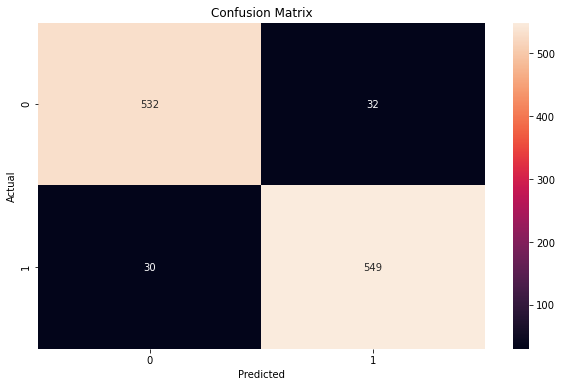

Accuracy "Without kernel": 0.9457567804024497 




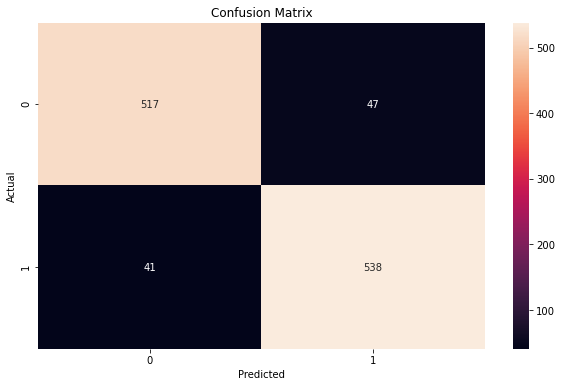

Accuracy "Linear kernel": 0.9230096237970253 




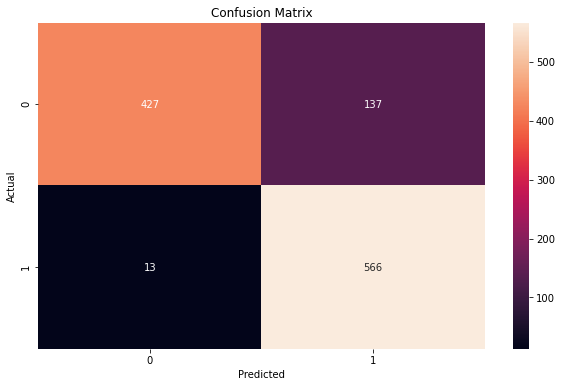

Accuracy "RBF kernel": 0.868766404199475 




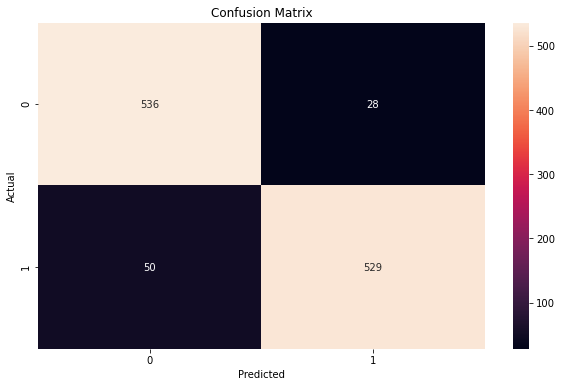

Accuracy "2nd degree Polynomial kernel": 0.931758530183727 




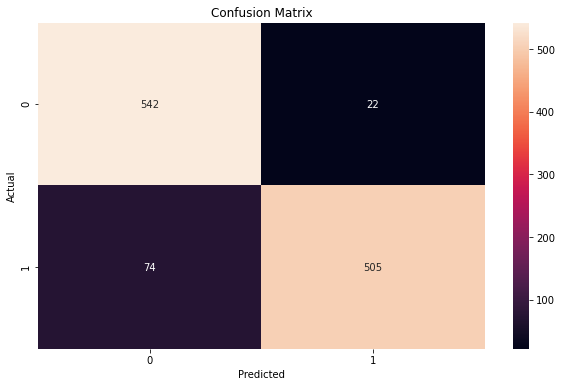

Accuracy "3nd degree Polynomial kernel": 0.916010498687664 




In [40]:
kernel_names = ["Without kernel", "Linear kernel", "RBF kernel",\
                "2nd degree Polynomial kernel", "3nd degree Polynomial kernel"]
accuracies = []
for i, model in enumerate(models):
    predict = model.predict(X_test)
    visualize_confusion_matrix(predict, y_test.flatten())
    print("Accuracy \"" + kernel_names[i] + str("\":"), (predict == y_test.flatten()).sum()/predict.size, "\n\n")
    